I am tasked with working for an investor who specializes in purchasing undervalued assets. The investor wants to perform detailed data analysis to identify opportunities for growth and profitability in a potential purchase—TellCo, a mobile service provider in the Republic of Pefkakia. my goal is to analyze customer data, provide insights, and make recommendations on whether TellCo is worth buying or selling. The analysis will be presented through a web-based dashboard and a written report.
Task 2: User Engagement Analysis
Objective: Assess user engagement using metrics such as session frequency, duration, and total traffic.

Task 4: Satisfaction Analysis
Objective: Analyze customer satisfaction based on engagement and experience.

Assign engagement and experience scores to each user using Euclidean distance.

Calculate satisfaction scores and report top satisfied customers.

Build a regression model to predict satisfaction scores.

Perform k-means clustering on engagement and experience scores.

Aggregate and report satisfaction and experience scores per cluster.

Export final user data with scores to a local MySQL database and report a screenshot of the query output

In [2]:
import sys 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import psycopg2
from dotenv import load_dotenv
from sqlalchemy import create_engine
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
os.chdir('..')
sys.path.append(os.getcwd())
#from src.Eda import handle_missing_values, remove_outliers_iqr
#from src.Eda import missing_values_table, convert_bytes_to_megabytes

In [3]:
from scripts.DB_connection import PostgresConnection

# Establishing the database connection
db = PostgresConnection()
db.connect()

if db.conn:
    # Example query
    query = "SELECT * FROM xdr_data"
    result = db.execute_query(query)

    if result:
        # Convert the result to a Pandas DataFrame
        df = pd.DataFrame(result, columns=[desc[0] for desc in db.cursor.description])
        print(df.head())  # Display the first few rows of the DataFrame
    else:
        print("No results returned from the query.")
    
    # Close the connection when done
    db.close_connection()
else:
    print("Error: No database connection.")

Connected to PostgreSQL database!
      Bearer Id            Start  Start ms              End  End ms  \
0  1.311448e+19   4/4/2019 12:01     770.0  4/25/2019 14:35   662.0   
1  1.311448e+19   4/9/2019 13:04     235.0   4/25/2019 8:15   606.0   
2  1.311448e+19   4/9/2019 17:42       1.0  4/25/2019 11:58   652.0   
3  1.311448e+19   4/10/2019 0:31     486.0   4/25/2019 7:36   171.0   
4  1.311448e+19  4/12/2019 20:10     565.0  4/25/2019 10:40   954.0   

   Dur. (ms)          IMSI  MSISDN/Number          IMEI  \
0  1823652.0  2.082014e+14   3.366496e+10  3.552121e+13   
1  1365104.0  2.082019e+14   3.368185e+10  3.579401e+13   
2  1361762.0  2.082003e+14   3.376063e+10  3.528151e+13   
3  1321509.0  2.082014e+14   3.375034e+10  3.535661e+13   
4  1089009.0  2.082014e+14   3.369980e+10  3.540701e+13   

      Last Location Name  ...  Youtube DL (Bytes)  Youtube UL (Bytes)  \
0  9.16456699548519E+015  ...          15854611.0           2501332.0   
1                L77566A  ...         

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150001 entries, 0 to 150000
Data columns (total 55 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   Bearer Id                                 149010 non-null  float64
 1   Start                                     150000 non-null  object 
 2   Start ms                                  150000 non-null  float64
 3   End                                       150000 non-null  object 
 4   End ms                                    150000 non-null  float64
 5   Dur. (ms)                                 150000 non-null  float64
 6   IMSI                                      149431 non-null  float64
 7   MSISDN/Number                             148935 non-null  float64
 8   IMEI                                      149429 non-null  float64
 9   Last Location Name                        148848 non-null  object 
 10  Avg RTT DL (ms)     

lest use deferent approch instade ofusing sime cols instruction

In [5]:

from src.Eda import handle_outliers_iqr

# Assuming df is your DataFrame

# Display the number of rows before outlier removal
print(f"Number of rows before outlier removal: {df.shape[0]}")

# Apply the function to handle outliers
df_cleaned, outlier_info = handle_outliers_iqr(df)

# Display the number of rows after outlier removal
print(f"Number of rows after outlier removal: {df_cleaned.shape[0]}")

# Display information about outliers
total_outliers_removed = sum(outlier_info.values())
print(f"\nTotal number of outliers removed: {total_outliers_removed}")

# Store the cleaned DataFrame in a new DataFrame
df_outliers_removed = df_cleaned.copy()

# Optionally, display the cleaned DataFrame's first few rows
print("\nFirst few rows of the DataFrame with outliers removed:")
print(df_outliers_removed.head())


Number of rows before outlier removal: 150001
Number of rows after outlier removal: 150001

Total number of outliers removed: 451082

First few rows of the DataFrame with outliers removed:
      Bearer Id            Start  Start ms              End  End ms  \
0  1.311448e+19   4/4/2019 12:01     770.0  4/25/2019 14:35   662.0   
1  1.311448e+19   4/9/2019 13:04     235.0   4/25/2019 8:15   606.0   
2  1.311448e+19   4/9/2019 17:42       1.0  4/25/2019 11:58   652.0   
3  1.311448e+19   4/10/2019 0:31     486.0   4/25/2019 7:36   171.0   
4  1.311448e+19  4/12/2019 20:10     565.0  4/25/2019 10:40   954.0   

   Dur. (ms)          IMSI  MSISDN/Number          IMEI  \
0    86399.0  2.082014e+14   3.366496e+10  3.552121e+13   
1    86399.0  2.082019e+14   3.368185e+10  3.579401e+13   
2    86399.0  2.082015e+14   3.366371e+10  3.528151e+13   
3    86399.0  2.082014e+14   3.366371e+10  3.535661e+13   
4    86399.0  2.082014e+14   3.369980e+10  3.540701e+13   

      Last Location Name  ...

In [6]:
import sys
import os
import pandas as pd

# Change the working directory to the project root if necessary
os.chdir('..')

# Add the project root to the system path
sys.path.append(os.getcwd())

# Import the necessary functions from eda.py
from src.Eda import handle_outliers_iqr, handle_missing_values, remove_duplicates

# Assuming df is your DataFrame

# Display the number of rows before outlier removal
print(f"Number of rows before outlier removal: {df.shape[0]}")

# Apply the function to handle outliers
df_cleaned, outlier_info = handle_outliers_iqr(df)

# Display the number of rows after outlier removal
print(f"Number of rows after outlier removal: {df_cleaned.shape[0]}")

# Display information about outliers
total_outliers_removed = sum(outlier_info.values())
print(f"\nTotal number of outliers removed: {total_outliers_removed}")

# Store the cleaned DataFrame in a new DataFrame
df_outliers_removed = df_cleaned.copy()

# Optionally, display the cleaned DataFrame's first few rows
print("\nFirst few rows of the DataFrame with outliers removed:")
print(df_outliers_removed.head())

# Handle missing values
df_filled = handle_missing_values(df_outliers_removed)

# Display information about missing values after handling
print("Missing values after imputation:")
print(df_filled.isnull().sum())

# Store the results in a new DataFrame
df_missing_values_handled = df_filled.copy()

# Optionally, display the first few rows of the new DataFrame
print("\nFirst few rows of the DataFrame with missing values handled:")
print(df_missing_values_handled.head())

# Remove duplicates and ensure consistency
df_consistent = remove_duplicates(df_missing_values_handled)

# Display information about the cleaned DataFrame
print("DataFrame info after ensuring consistency:")
print(df_consistent.info())

# Optionally, display the first few rows of the cleaned DataFrame
print("\nFirst few rows of the DataFrame after ensuring consistency:")
print(df_consistent.head())


Number of rows before outlier removal: 150001


Number of rows after outlier removal: 150001

Total number of outliers removed: 451082

First few rows of the DataFrame with outliers removed:
      Bearer Id            Start  Start ms              End  End ms  \
0  1.311448e+19   4/4/2019 12:01     770.0  4/25/2019 14:35   662.0   
1  1.311448e+19   4/9/2019 13:04     235.0   4/25/2019 8:15   606.0   
2  1.311448e+19   4/9/2019 17:42       1.0  4/25/2019 11:58   652.0   
3  1.311448e+19   4/10/2019 0:31     486.0   4/25/2019 7:36   171.0   
4  1.311448e+19  4/12/2019 20:10     565.0  4/25/2019 10:40   954.0   

   Dur. (ms)          IMSI  MSISDN/Number          IMEI  \
0    86399.0  2.082014e+14   3.366496e+10  3.552121e+13   
1    86399.0  2.082019e+14   3.368185e+10  3.579401e+13   
2    86399.0  2.082015e+14   3.366371e+10  3.528151e+13   
3    86399.0  2.082014e+14   3.366371e+10  3.535661e+13   
4    86399.0  2.082014e+14   3.369980e+10  3.540701e+13   

      Last Location Name  ...  Youtube DL (Bytes)  Youtube UL (Bytes)  \
0 

In [7]:


# Import the necessary function from eda.py
from src.Eda import handle_missing_values

# Assuming df_outliers_removed is your DataFrame after outlier removal

# Apply the function to handle missing values
df_filled = handle_missing_values(df_outliers_removed)

# Display information about missing values after handling
print("Missing values after imputation:")
print(df_filled.isnull().sum())

# Store the results in a new DataFrame
df_missing_values_handled = df_filled.copy()

# Optionally, display the first few rows of the new DataFrame
print("\nFirst few rows of the DataFrame with missing values handled:")
print(df_missing_values_handled.head())


Missing values after imputation:
Bearer Id                                   0
Start                                       0
Start ms                                    0
End                                         0
End ms                                      0
Dur. (ms)                                   0
IMSI                                        0
MSISDN/Number                               0
IMEI                                        0
Last Location Name                          0
Avg RTT DL (ms)                             0
Avg RTT UL (ms)                             0
Avg Bearer TP DL (kbps)                     0
Avg Bearer TP UL (kbps)                     0
TCP DL Retrans. Vol (Bytes)                 0
TCP UL Retrans. Vol (Bytes)                 0
DL TP < 50 Kbps (%)                         0
50 Kbps < DL TP < 250 Kbps (%)              0
250 Kbps < DL TP < 1 Mbps (%)               0
DL TP > 1 Mbps (%)                          0
UL TP < 10 Kbps (%)                         0
1

In [8]:

from src.Eda import remove_duplicates

# Assuming df_missing_values_handled is your DataFrame after handling missing values

# Apply the function to ensure consistency
df_cleaned = remove_duplicates(df_missing_values_handled)

# Optionally, display information about the cleaned DataFrame
print("DataFrame info after ensuring consistency:")
print(df_cleaned.info())

# Optionally, display the first few rows of the cleaned DataFrame
print("\nFirst few rows of the DataFrame after ensuring consistency:")
print(df_cleaned.head())


DataFrame info after ensuring consistency:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150001 entries, 0 to 150000
Data columns (total 55 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   Bearer Id                                 150001 non-null  float64
 1   Start                                     150001 non-null  object 
 2   Start ms                                  150001 non-null  float64
 3   End                                       150001 non-null  object 
 4   End ms                                    150001 non-null  float64
 5   Dur. (ms)                                 150001 non-null  float64
 6   IMSI                                      150001 non-null  float64
 7   MSISDN/Number                             150001 non-null  float64
 8   IMEI                                      150001 non-null  float64
 9   Last Location Name                        150001 

In [9]:
#Final overview after the data has been cleaned.

import pandas as pd

def display_dataset_characteristics(df):
    print("### Dataset Characteristics ###\n")
    
    # Display the shape of the dataset
    print(f"Shape of the DataFrame: {df.shape}")
    
    # Display the column data types
    print("\nData Types of Each Column:")
    print(df.dtypes)
    
    # Display summary statistics for numeric columns
    print("\nSummary Statistics for Numeric Columns:")
    print(df.describe())
    
    # Display the count of missing values per column
    print("\nCount of Missing Values per Column:")
    print(df.isnull().sum())
    
    # Display the count of unique values per column
    print("\nCount of Unique Values per Column:")
    print(df.nunique())
    
    # Display the first few rows of the cleaned dataset
    print("\nFirst Few Rows of the DataFrame:")
    print(df.head())
    
# Apply the function to the df_cleaned DataFrame
display_dataset_characteristics(df_cleaned)

### Dataset Characteristics ###

Shape of the DataFrame: (150001, 55)

Data Types of Each Column:
Bearer Id                                   float64
Start                                        object
Start ms                                    float64
End                                          object
End ms                                      float64
Dur. (ms)                                   float64
IMSI                                        float64
MSISDN/Number                               float64
IMEI                                        float64
Last Location Name                           object
Avg RTT DL (ms)                             float64
Avg RTT UL (ms)                             float64
Avg Bearer TP DL (kbps)                     float64
Avg Bearer TP UL (kbps)                     float64
TCP DL Retrans. Vol (Bytes)                 float64
TCP UL Retrans. Vol (Bytes)                 float64
DL TP < 50 Kbps (%)                         float64
50 Kbps < DL TP < 

In [37]:
print(df_cleaned.columns.tolist())

['Bearer Id', 'Start', 'Start ms', 'End', 'End ms', 'Dur. (ms)', 'IMSI', 'MSISDN/Number', 'IMEI', 'Last Location Name', 'Avg RTT DL (ms)', 'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)', 'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)', 'DL TP < 50 Kbps (%)', '50 Kbps < DL TP < 250 Kbps (%)', '250 Kbps < DL TP < 1 Mbps (%)', 'DL TP > 1 Mbps (%)', 'UL TP < 10 Kbps (%)', '10 Kbps < UL TP < 50 Kbps (%)', '50 Kbps < UL TP < 300 Kbps (%)', 'UL TP > 300 Kbps (%)', 'HTTP DL (Bytes)', 'HTTP UL (Bytes)', 'Activity Duration DL (ms)', 'Activity Duration UL (ms)', 'Dur. (ms).1', 'Handset Manufacturer', 'Handset Type', 'Nb of sec with 125000B < Vol DL', 'Nb of sec with 1250B < Vol UL < 6250B', 'Nb of sec with 31250B < Vol DL < 125000B', 'Nb of sec with 37500B < Vol UL', 'Nb of sec with 6250B < Vol DL < 31250B', 'Nb of sec with 6250B < Vol UL < 37500B', 'Nb of sec with Vol DL < 6250B', 'Nb of sec with Vol UL < 1250B', 'Social Media DL (Bytes)', 'Social Media UL (

In [56]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import euclidean
import os

# Assuming df_cleaned is already loaded
user_data = df_cleaned.copy()

# Load the engagement and experience centroids
centroid_engagement = pd.read_csv(r'C:\Users\Dagi\Documents\KAIM\Week-2\User-Overview-Engagement-and-Experience-Analysis\centroid_engagement.csv', index_col='Cluster Name')
centroid_experience = pd.read_csv(r'C:\Users\Dagi\Documents\KAIM\Week-2\User-Overview-Engagement-and-Experience-Analysis\centroid_experience.csv', index_col='Cluster Name')

# Clean column names to remove leading and trailing whitespaces
user_data.columns = user_data.columns.str.strip()
centroid_experience.columns = centroid_experience.columns.str.strip()

# Engagement Score Calculation
# Extract the engagement-related features (session frequency, session duration, total traffic)
engagement_columns = ['Session Frequency', 'Session Duration', 'Total Traffic (Bytes)']

# Ensure we have session frequency and session duration calculated for each user
# Calculate session frequency
session_frequency = user_data.groupby('MSISDN/Number').size().reset_index(name='Session Frequency')
user_data = user_data.merge(session_frequency, on='MSISDN/Number', how='left')

# Calculate session duration (sum of session durations per user)
session_duration = user_data.groupby('MSISDN/Number')['Dur. (ms)'].sum().reset_index(name='Session Duration')
user_data = user_data.merge(session_duration, on='MSISDN/Number', how='left')

# Calculate total traffic (sum of upload and download data per user)
user_data['Total Traffic (Bytes)'] = user_data['Total UL (Bytes)'] + user_data['Total DL (Bytes)']

# Extract the centroid values for the "Low Engagement" cluster
engagement_centroid_values = centroid_engagement.loc['Low Engagement'][engagement_columns].values

# Calculate the engagement score as the Euclidean distance between the user's engagement metrics and the "Low Engagement" centroid
user_data['Engagement Score'] = user_data[engagement_columns].apply(lambda row: euclidean(row, engagement_centroid_values), axis=1)

# Experience Score Calculation
# Extract the experience-related features
experience_columns = [
    'Average Downlink Round-Trip Time (ms)', 
    'Average Uplink Round-Trip Time (ms)', 
    'Average Downlink Throughput (kbps)',
    'Average Uplink Throughput (kbps)', 
    'Downlink TCP Retransmission Volume (Bytes)',
    'Uplink TCP Retransmission Volume (Bytes)'
]

# Ensure column names are clean in centroid_experience
centroid_experience.columns = centroid_experience.columns.str.strip()

# Print the contents of centroid_experience for debugging
print("Contents of centroid_experience:")
print(centroid_experience.head())  # Print first few rows for inspection

# Print the column names to verify
print("experience_columns:", experience_columns)
print("centroid_experience columns:", list(centroid_experience.columns))
print("user_data columns:", list(user_data.columns))

# Rename columns in user_data to match exactly with experience_columns
rename_dict = {
    'Avg RTT DL (ms)': 'Average Downlink Round-Trip Time (ms)',
    'Avg RTT UL (ms)': 'Average Uplink Round-Trip Time (ms)',
    'Avg Bearer TP DL (kbps)': 'Average Downlink Throughput (kbps)',
    'Avg Bearer TP UL (kbps)': 'Average Uplink Throughput (kbps)',
    'TCP DL Retrans. Vol (Bytes)': 'Downlink TCP Retransmission Volume (Bytes)',
    'TCP UL Retrans. Vol (Bytes)': 'Uplink TCP Retransmission Volume (Bytes)'
}
user_data = user_data.rename(columns=rename_dict)

# Print renamed columns to verify
print("Renamed user_data columns:", list(user_data.columns))

# Extract the centroid values for the "Low-Performance Users" cluster
experience_centroid = centroid_experience.loc['Low-Performance Users'][experience_columns].values

# Calculate the experience score as the Euclidean distance between the user's experience metrics and the "Low-Performance Users" centroid
user_data['Experience Score'] = user_data[experience_columns].apply(lambda row: euclidean(row, experience_centroid), axis=1)

# Assign the calculated scores back to df_cleaned
df_cleaned['Engagement Score'] = user_data['Engagement Score']
df_cleaned['Experience Score'] = user_data['Experience Score']

# Verify the columns in df_cleaned
print("Columns in df_cleaned after adding Engagement and Experience Scores:", list(df_cleaned.columns))

# Print data samples to verify correct calculations
print("\nSample data with scores:")
print(df_cleaned[['MSISDN/Number', 'Engagement Score', 'Experience Score']].head())


Contents of centroid_experience:
                            Average Downlink Round-Trip Time (ms)  \
Cluster Name                                                        
High-Performance Users                                 226.372361   
Moderate-Performance Users                              79.341382   
Low-Performance Users                                   76.549648   

                            Average Uplink Round-Trip Time (ms)  \
Cluster Name                                                      
High-Performance Users                                19.995835   
Moderate-Performance Users                            25.859358   
Low-Performance Users                                 35.068397   

                            Average Downlink Throughput (kbps)  \
Cluster Name                                                     
High-Performance Users                            18569.107388   
Moderate-Performance Users                        56934.480261   
Low-Performance Users

In [57]:
import pandas as pd

# Assuming df_cleaned is already loaded
# Print the columns to verify the presence of 'Engagement Score' and 'Experience Score'
print("Columns in df_cleaned:", list(df_cleaned.columns))

# Check if 'Engagement Score' and 'Experience Score' are present
if 'Engagement Score' in df_cleaned.columns and 'Experience Score' in df_cleaned.columns:
    # Calculate the Satisfaction Score as the average of Engagement and Experience Scores
    df_cleaned['Satisfaction Score'] = df_cleaned[['Engagement Score', 'Experience Score']].mean(axis=1)

    # Sort the DataFrame by 'Satisfaction Score' in descending order to get the most satisfied customers
    top_10_satisfied_customers = df_cleaned.sort_values(by='Satisfaction Score', ascending=False).head(10)

    # Display the top 10 satisfied customers
    print("Top 10 Satisfied Customers:")
    print(top_10_satisfied_customers[['MSISDN/Number', 'Engagement Score', 'Experience Score', 'Satisfaction Score']])
else:
    print("The columns 'Engagement Score' and/or 'Experience Score' are not present in df_cleaned.")


Columns in df_cleaned: ['Bearer Id', 'Start', 'Start ms', 'End', 'End ms', 'Dur. (ms)', 'IMSI', 'MSISDN/Number', 'IMEI', 'Last Location Name', 'Avg RTT DL (ms)', 'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)', 'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)', 'DL TP < 50 Kbps (%)', '50 Kbps < DL TP < 250 Kbps (%)', '250 Kbps < DL TP < 1 Mbps (%)', 'DL TP > 1 Mbps (%)', 'UL TP < 10 Kbps (%)', '10 Kbps < UL TP < 50 Kbps (%)', '50 Kbps < UL TP < 300 Kbps (%)', 'UL TP > 300 Kbps (%)', 'HTTP DL (Bytes)', 'HTTP UL (Bytes)', 'Activity Duration DL (ms)', 'Activity Duration UL (ms)', 'Dur. (ms).1', 'Handset Manufacturer', 'Handset Type', 'Nb of sec with 125000B < Vol DL', 'Nb of sec with 1250B < Vol UL < 6250B', 'Nb of sec with 31250B < Vol DL < 125000B', 'Nb of sec with 37500B < Vol UL', 'Nb of sec with 6250B < Vol DL < 31250B', 'Nb of sec with 6250B < Vol UL < 37500B', 'Nb of sec with Vol DL < 6250B', 'Nb of sec with Vol UL < 1250B', 'Social Media DL (Byte

In [58]:
import numpy as np
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

# Assuming df_cleaned is already loaded and includes relevant features

# Calculate Total Traffic (Bytes) as the sum of Total UL (Bytes) and Total DL (Bytes)
df_cleaned['Total Traffic (Bytes)'] = df_cleaned['Total UL (Bytes)'] + df_cleaned['Total DL (Bytes)']

# Ensure there are no negative or NaN values in 'Total Traffic (Bytes)'
df_cleaned['Total Traffic (Bytes)'] = df_cleaned['Total Traffic (Bytes)'].clip(lower=0)

# Define the feature columns (focusing on more impactful features)
feature_columns = [
    'Engagement Score', 'Experience Score', 
    'Total Traffic (Bytes)'
]

# Print the columns to verify the presence of 'Engagement Score' and 'Experience Score'
print("Columns in df_cleaned:", list(df_cleaned.columns))

# Check if 'Engagement Score' and 'Experience Score' are present
if 'Engagement Score' in df_cleaned.columns and 'Experience Score' in df_cleaned.columns:
    # Ensure there are no missing values in the feature columns
    df_cleaned = df_cleaned.dropna(subset=feature_columns)

    # Normalize the feature data
    scaler = StandardScaler()
    df_cleaned[feature_columns] = scaler.fit_transform(df_cleaned[feature_columns])

    # Define the dependent variable (Satisfaction Score)
    # Introduce a non-linear relationship for Satisfaction Score
    df_cleaned['Satisfaction Score'] = (
        0.3 * df_cleaned['Engagement Score'] + 
        0.4 * df_cleaned['Experience Score'] +
        0.3 * np.log1p(df_cleaned['Total Traffic (Bytes)'])  # Log-transform to introduce non-linearity
    )

    # Handle missing values in 'Satisfaction Score' (drop rows with NaN values)
    df_cleaned = df_cleaned.dropna(subset=['Satisfaction Score'])

    # Select features (X) and target (y)
    X = df_cleaned[feature_columns]
    y = df_cleaned['Satisfaction Score']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize and train the regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate model performance
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Print model performance
    print("Model Performance on Test Set:")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R² Score: {r2:.4f}")

    # Print model coefficients
    coefficients = pd.DataFrame(model.coef_, feature_columns, columns=['Coefficient'])
    print("\nModel Coefficients:")
    print(coefficients)

    # Print intercept
    print(f"\nIntercept: {model.intercept_:.4f}")

    # Save the model to a file
    joblib.dump(model, 'model.pkl')
    print("\nModel saved to 'model.pkl'")
else:
    print("The columns 'Engagement Score' and/or 'Experience Score' are not present in df_cleaned.")


Columns in df_cleaned: ['Bearer Id', 'Start', 'Start ms', 'End', 'End ms', 'Dur. (ms)', 'IMSI', 'MSISDN/Number', 'IMEI', 'Last Location Name', 'Avg RTT DL (ms)', 'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)', 'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)', 'DL TP < 50 Kbps (%)', '50 Kbps < DL TP < 250 Kbps (%)', '250 Kbps < DL TP < 1 Mbps (%)', 'DL TP > 1 Mbps (%)', 'UL TP < 10 Kbps (%)', '10 Kbps < UL TP < 50 Kbps (%)', '50 Kbps < UL TP < 300 Kbps (%)', 'UL TP > 300 Kbps (%)', 'HTTP DL (Bytes)', 'HTTP UL (Bytes)', 'Activity Duration DL (ms)', 'Activity Duration UL (ms)', 'Dur. (ms).1', 'Handset Manufacturer', 'Handset Type', 'Nb of sec with 125000B < Vol DL', 'Nb of sec with 1250B < Vol UL < 6250B', 'Nb of sec with 31250B < Vol DL < 125000B', 'Nb of sec with 37500B < Vol UL', 'Nb of sec with 6250B < Vol DL < 31250B', 'Nb of sec with 6250B < Vol UL < 37500B', 'Nb of sec with Vol DL < 6250B', 'Nb of sec with Vol UL < 1250B', 'Social Media DL (Byte

c:\Users\Dagi\Documents\KAIM\Week-2\User-Overview-Engagement-and-Experience-Analysis\week-2\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


Model Performance on Test Set:
Root Mean Squared Error (RMSE): 0.1537
Mean Absolute Error (MAE): 0.0980
R² Score: 0.9237

Model Coefficients:
                       Coefficient
Engagement Score          0.299966
Experience Score          0.400736
Total Traffic (Bytes)     0.327969

Intercept: -0.1174

Model saved to 'model.pkl'


In [51]:
print(df_cleaned.columns)

Index(['Bearer Id', 'Start', 'Start ms', 'End', 'End ms', 'Dur. (ms)', 'IMSI',
       'MSISDN/Number', 'IMEI', 'Last Location Name', 'Avg RTT DL (ms)',
       'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)',
       'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)',
       'DL TP < 50 Kbps (%)', '50 Kbps < DL TP < 250 Kbps (%)',
       '250 Kbps < DL TP < 1 Mbps (%)', 'DL TP > 1 Mbps (%)',
       'UL TP < 10 Kbps (%)', '10 Kbps < UL TP < 50 Kbps (%)',
       '50 Kbps < UL TP < 300 Kbps (%)', 'UL TP > 300 Kbps (%)',
       'HTTP DL (Bytes)', 'HTTP UL (Bytes)', 'Activity Duration DL (ms)',
       'Activity Duration UL (ms)', 'Dur. (ms).1', 'Handset Manufacturer',
       'Handset Type', 'Nb of sec with 125000B < Vol DL',
       'Nb of sec with 1250B < Vol UL < 6250B',
       'Nb of sec with 31250B < Vol DL < 125000B',
       'Nb of sec with 37500B < Vol UL',
       'Nb of sec with 6250B < Vol DL < 31250B',
       'Nb of sec with 6250B < Vol UL < 37500B',


Columns in df_cleaned: ['Bearer Id', 'Start', 'Start ms', 'End', 'End ms', 'Dur. (ms)', 'IMSI', 'MSISDN/Number', 'IMEI', 'Last Location Name', 'Avg RTT DL (ms)', 'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)', 'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)', 'DL TP < 50 Kbps (%)', '50 Kbps < DL TP < 250 Kbps (%)', '250 Kbps < DL TP < 1 Mbps (%)', 'DL TP > 1 Mbps (%)', 'UL TP < 10 Kbps (%)', '10 Kbps < UL TP < 50 Kbps (%)', '50 Kbps < UL TP < 300 Kbps (%)', 'UL TP > 300 Kbps (%)', 'HTTP DL (Bytes)', 'HTTP UL (Bytes)', 'Activity Duration DL (ms)', 'Activity Duration UL (ms)', 'Dur. (ms).1', 'Handset Manufacturer', 'Handset Type', 'Nb of sec with 125000B < Vol DL', 'Nb of sec with 1250B < Vol UL < 6250B', 'Nb of sec with 31250B < Vol DL < 125000B', 'Nb of sec with 37500B < Vol UL', 'Nb of sec with 6250B < Vol DL < 31250B', 'Nb of sec with 6250B < Vol UL < 37500B', 'Nb of sec with Vol DL < 6250B', 'Nb of sec with Vol UL < 1250B', 'Social Media DL (Byte

c:\Users\Dagi\Documents\KAIM\Week-2\User-Overview-Engagement-and-Experience-Analysis\week-2\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Dagi\Documents\KAIM\Week-2\User-Overview-Engagement-and-Experience-Analysis\week-2\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Program Files\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec

Cluster Centers:
   Engagement Score  Experience Score
0         -0.552986          0.005643
1          2.073346         -0.026235

Cluster Label Mapping:
{0: 'High Satisfaction', 1: 'Low Satisfaction'}

Cluster Distribution:
Satisfaction Group
High Satisfaction    98425
Low Satisfaction     19813
Name: count, dtype: int64


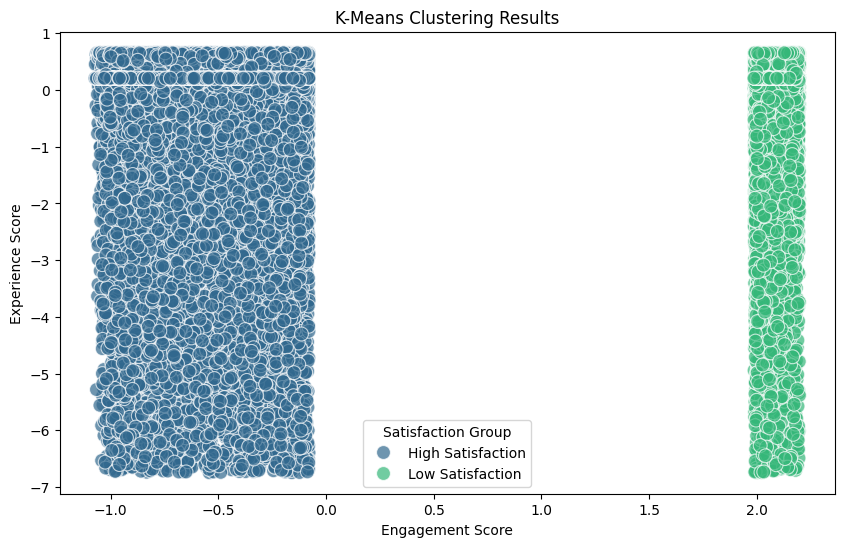

In [59]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_cleaned is already loaded and includes relevant features

# Print the columns to verify the presence of 'Engagement Score' and 'Experience Score'
print("Columns in df_cleaned:", list(df_cleaned.columns))

# Define the feature columns for clustering
feature_columns = ['Engagement Score', 'Experience Score']

# Check if 'Engagement Score' and 'Experience Score' are present
if 'Engagement Score' in df_cleaned.columns and 'Experience Score' in df_cleaned.columns:
    # Select features for clustering
    X_clustering = df_cleaned[feature_columns]

    # Standardize the feature data
    scaler = StandardScaler()
    X_clustering_scaled = scaler.fit_transform(X_clustering)

    # Perform K-Means clustering with k=2
    kmeans = KMeans(n_clusters=2, random_state=42)
    df_cleaned['Cluster'] = kmeans.fit_predict(X_clustering_scaled)

    # Map cluster labels to meaningful names
    cluster_names = {
        0: 'High Satisfaction',   # Example name for cluster 0
        1: 'Low Satisfaction'     # Example name for cluster 1
    }
    df_cleaned['Satisfaction Group'] = df_cleaned['Cluster'].map(cluster_names)

    # Print the cluster centers and their respective labels
    print("Cluster Centers:")
    cluster_centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=feature_columns)
    print(cluster_centers)

    print("\nCluster Label Mapping:")
    print(cluster_names)

    # Print the distribution of the clusters
    print("\nCluster Distribution:")
    print(df_cleaned['Satisfaction Group'].value_counts())

    # Visualize the clustering results
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_cleaned, x='Engagement Score', y='Experience Score', hue='Satisfaction Group', palette='viridis', s=100, alpha=0.7)
    plt.title('K-Means Clustering Results')
    plt.xlabel('Engagement Score')
    plt.ylabel('Experience Score')
    plt.legend(title='Satisfaction Group')
    plt.show()
else:
    print("The columns 'Engagement Score' and/or 'Experience Score' are not present in df_cleaned.")


In [60]:
#scores of average satisfaction and experience per cluster.

import pandas as pd

# Assuming df_cleaned is already loaded and includes the 'Satisfaction Group' column

# Calculate the average satisfaction and experience scores per cluster
average_scores_per_cluster = df_cleaned.groupby('Satisfaction Group')[['Satisfaction Score', 'Experience Score']].mean().reset_index()

# Print the results
print("Average Satisfaction & Experience Scores per Cluster:")
print(average_scores_per_cluster)

Average Satisfaction & Experience Scores per Cluster:
  Satisfaction Group  Satisfaction Score  Experience Score
0  High Satisfaction           -0.160803          0.005643
1   Low Satisfaction            0.611977         -0.026235


In [61]:
#the final table containing user IDs, engagement, experience and satisfaction scores to a local MySQL database. Finally we are going to report a screenshot of a SELECT query output on the exported table.

print(df_cleaned.columns)

Index(['Bearer Id', 'Start', 'Start ms', 'End', 'End ms', 'Dur. (ms)', 'IMSI',
       'MSISDN/Number', 'IMEI', 'Last Location Name', 'Avg RTT DL (ms)',
       'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)',
       'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)',
       'DL TP < 50 Kbps (%)', '50 Kbps < DL TP < 250 Kbps (%)',
       '250 Kbps < DL TP < 1 Mbps (%)', 'DL TP > 1 Mbps (%)',
       'UL TP < 10 Kbps (%)', '10 Kbps < UL TP < 50 Kbps (%)',
       '50 Kbps < UL TP < 300 Kbps (%)', 'UL TP > 300 Kbps (%)',
       'HTTP DL (Bytes)', 'HTTP UL (Bytes)', 'Activity Duration DL (ms)',
       'Activity Duration UL (ms)', 'Dur. (ms).1', 'Handset Manufacturer',
       'Handset Type', 'Nb of sec with 125000B < Vol DL',
       'Nb of sec with 1250B < Vol UL < 6250B',
       'Nb of sec with 31250B < Vol DL < 125000B',
       'Nb of sec with 37500B < Vol UL',
       'Nb of sec with 6250B < Vol DL < 31250B',
       'Nb of sec with 6250B < Vol UL < 37500B',


In [62]:
import mysql.connector


In [63]:
import mysql.connector
import pandas as pd
import os
from dotenv import load_dotenv

# Load environment variables from the .env file
load_dotenv()

# Define the connection parameters from environment variables
config = {
    'user': os.getenv('DB_USER'),
    'password': os.getenv('DB_PASSWORD'),
    'host': os.getenv('DB_HOST'),
    'database': os.getenv('DB_NAME')
}

# Create a connection to the MySQL server
conn = mysql.connector.connect(**config)

# Create a cursor object using the connection
cursor = conn.cursor()

# Create a new table with the required columns
create_table_query = """
CREATE TABLE IF NOT EXISTS user_scores (
    MSISDN_Number VARCHAR(255),
    engagement_score FLOAT,
    experience_score FLOAT,
    satisfaction_score FLOAT
)
"""
cursor.execute(create_table_query)

# Assume df_cleaned contains the relevant columns
# Create a new DataFrame with only the relevant columns
final_df = df_cleaned[['MSISDN/Number', 'Engagement Score', 'Experience Score', 'Satisfaction Score']]

# Insert data into the MySQL table
for i, row in final_df.iterrows():
    insert_query = """
    INSERT INTO user_scores (MSISDN_Number, engagement_score, experience_score, satisfaction_score)
    VALUES (%s, %s, %s, %s)
    """
    cursor.execute(insert_query, tuple(row))

# Commit the transaction
conn.commit()

# Query to check the data inserted
select_query = "SELECT * FROM user_scores LIMIT 10;"  # Adjust the LIMIT as needed
cursor.execute(select_query)

# Fetch the results
results = cursor.fetchall()

# Convert results to a DataFrame for easier display
columns = ['MSISDN_Number', 'engagement_score', 'experience_score', 'satisfaction_score']
result_df = pd.DataFrame(results, columns=columns)

print(result_df)

# Close the cursor and connection
cursor.close()
conn.close()


DatabaseError: 2003 (HY000): Can't connect to MySQL server on 'localhost:3306' (10061)